In [119]:
import numpy as np
import pandas as pd

In [120]:
class Player:
    def __init__(self, num, ally_num, tag="player1"):
        self.tag = tag
        self.pos = 0
        self.num = num
        self.ally_num = ally_num
        self.prev_pos = []
        self.posession_indices = []
        
    def change_pos(self, roll_dice, num_states):
        self.pos = (self.pos + roll_dice) % num_states

    def buy(self, board):
        self.posession_indices.append(self.pos)
        board[self.pos] = self.num
        return board

    def sell(self, board, p2_num):
        if self.pos in self.posession_indices:
            self.posession_indices.remove(self.pos)
            board[self.pos] = p2_num
        else:
            pass
        return board

In [154]:
class MonopolyEnv:
    def __init__(self, num_states, max_turns=100):
        self.actions = ["skip", "buy", "give"]
        self.done = False
        self.episode_length = 0
        self.no_operation = False
        
        self.num_states = num_states
        self.board = np.zeros(self.num_states)
        self.state_observation = [0, self.board]
        self.max_turns = max_turns
        
    def reset(self):
        self.done = False
        self.episode_length = 0
        # self.x = 0
        self.board = np.zeros(self.num_states)
        
        self.players = [Player(1, 2, "player1"), Player(2, 1, "player2")]
        # for i in range(num_agents):
        #     players.append(Player(i+1, f"player{i+1}"))
        # players[0] = Player(1, 2, "player1")
        # players[1] = Player(2, 1, "player2")

        self.current_player_index = 0
        self.current_player = self.players[self.current_player_index]
        
        # self.learnable_agents = self.players[1:]
        self.static_agents = self.players[1:]
        
        # self.state_observation = [self.x, self.board]
        self.state_observation = [self.current_player.pos, self.board]
        
        return [self.current_player.pos, self.board]
    
    def action_space(self):
        return self.actions

    def update_position_roll(self):
        roll = np.random.randint(low=1, high=3)
        self.current_player.change_pos(roll, self.num_states)
        # self.x = (self.x + roll) % self.num_states
        # return [self.x, self.board]
        return [self.current_player.pos, self.board]
    
    def step(self, action):      
        if self.episode_length > self.max_turns:
            self.done = True
            self.no_operation = True
            return self.state_observation, self.reward, self.done, self.no_operation, self.episode_length
            
        if np.all(self.board == 2):
            self.done = True
            self.no_operation = True
            return self.state_observation, self.reward, self.done, self.no_operation, self.episode_length

        self.action = action
        # self.action = self.actions[action]
        self.reward = self.get_reward()
        self.state_observation = self.take_action()
        self.episode_length += 1
        self.no_operation = False
        
        if(self.episode_length >= self.max_turns):
            self.done = True

        for static_agent in self.static_agents:
            self.move_static_agent(static_agent)
            
        return self.state_observation, self.reward, self.done, self.no_operation, self.episode_length
    
    def get_reward(self):
        '''
        Return value : rewards
        Input argument. 
        '''
        self.reward = 0
        if self.board[self.current_player.pos] == 0:
            if self.action == "buy":
                self.reward += 0
            elif self.action == "give":
                # Invalid action
                self.reward += -10
            else:
                # Skipping even when it can buy
                self.reward += -2

        elif self.board[self.current_player.pos] == 1:
            if self.action == "buy":
                # Trying to buy already bought land
                self.reward += -1
            elif self.action == "give":
                # Good action
                self.reward += 1
            else:
                # Skipping even when it can sell
                self.reward += -2

        else:
            if self.action == "buy":
                # Trying to buy already bought land
                self.reward += -1
            elif self.action == "give":
                # Invalid action
                self.reward += -1
            else:
                # Skipping correct action
                self.reward += 0

        if np.all(self.board == 2):
            self.reward += 5
        else:
            self.reward += -1
    
        return self.reward
    
    def take_action(self):
        if self.action == "buy":
            if int(self.board[self.current_player.pos]) == 0:        
                self.board[self.current_player.pos] = self.current_player.num
                
        elif self.action == "give":
            if int(self.board[self.current_player.pos]) == self.current_player.num:
                self.board[self.current_player.pos] = self.current_player.ally_num
                
        return [self.current_player.pos, self.board]

    def move_static_agent(self, static_agent):
        roll = np.random.randint(low=1, high=3)
        static_agent.change_pos(roll, self.num_states)
        action_in = np.random.choice([0, 1])
        action = self.actions[action_in]
        
        if action == "buy":
            if int(self.board[static_agent.pos]) == 0:
                self.board[static_agent.pos] = static_agent.num

### Code for the agent to test environment

In [155]:
'''Functions for the agent'''
def best_state_action_value(current_state):
    max_val = np.inf*-1
#     from IPython.core.debugger import Tracer; Tracer()() 
    for key in current_state.keys():
        if current_state[key] > max_val:
            max_val = current_state[key]
            best_action = key
    return best_action, max_val

# def current_state_to_string(state):
#     current_state = ''.join(str(int(e)) for e in state)
#     return current_state
# self.x self.board
def current_state_to_string(state):
    x = state[0]
    board = state[1]
    # current_state = ''.join(x).join(board[x])
    current_state = f"{int(x)}{int(board[x])}"
    
    # current_state = ''.join(str(int(e)) for e in state)
    return current_state


def get_all_states_as_strings(num_states, num_agents):
    states = []
    for i in range(num_states):
        for j in range(num_agents+1):
            tmp = [i,j]
            states.append("".join(str(a) for a in tmp))
    # print(states)
    return states

def initialize_Q(num_states, num_agents):
    Q = {}
    states = get_all_states_as_strings(num_states, num_agents)
    for state in states:
        Q[state] = {}
        for i in range(3): #Number of actions = 3
            Q[state][i] = np.random.uniform(-2,2,1)
            # Q[state][i] = -10
    return Q


In [156]:
# MAX_STATES = MAX_HOR_LENGTH*MAX_HOR_LENGTH
num_states = 10
num_agents = 2

TOTAL_EPISODES = 1000
SIM_RUN = 10
SHOW_EVERY = 10
OBSERVATION_SPACE = 2
# LEARNING_RATE = 0.05 # alpha in the literature
LEARNING_RATE = 0.05 # alpha in the literature
DISCOUNT = 0.95 # gamma IN the literature
EPSILON = 0.1
START_EPSILON_DECAYING = 150
END_EPSILON_DECAYING = 600
epsilon_decay_value = EPSILON/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
# debug = True
debug = False
Summed_reward = []

In [157]:
for sim in range(SIM_RUN):
    EPSILON = 0.1 
    done = False
    
    agent = MonopolyEnv(num_states, 150)
    Q_table = initialize_Q(num_states, num_agents)

    Total_running_reward = []
    action_space = agent.action_space()
    action_indexes = [i for i in range(len(action_space))]
    cnt = 0
    no_op = False
    episode_lengths = []
    for episode in range(TOTAL_EPISODES):
        done = False
        current_state = agent.reset()
        cnt += 1
        total_episode_reward = 0
        episode_length = 0

        while not done:
            current_state = agent.update_position_roll()
            if debug:
                print(f"currentagent: {agent.current_player.num}, Agent.x: {current_state[0]}")

            if agent.current_player.num != 1:
                print("SOMETHING IS WRONG!!!")
            
            current_state_str = current_state_to_string(current_state)
            kind_of_selection_ = 'None'

            if np.random.uniform() > EPSILON:
                action, max_qt1 = best_state_action_value(Q_table[current_state_str])
                kind_of_selection_ = 'Greedy'
            else:
                action = np.random.choice(action_indexes)
                max_qt1 = Q_table[current_state_str][action]
                kind_of_selection_ = 'Random'

            if debug:
                print(f"action: {action_space[action]}, current_state: {current_state_str}")
                print(f"Before action: {current_state}")
            
            next_state, reward, done, no_op, episode_length = agent.step(action_space[action])
            total_episode_reward += reward
            
            if debug:
                print(f"After action: {next_state}")
                print(f"reward: {reward}")
                print(f"---------------------------------------")
                
            Q_table[current_state_str][action] += LEARNING_RATE*(reward + DISCOUNT*max_qt1 - Q_table[current_state_str][action])
#             print(f'current state : {current_state}. Action : {action_space[action]}. Next state: {next_state}. Kind of Sel: {kind_of_selection_}')
            current_state = next_state
            # print(current_state)
            cnt+=1

        Total_running_reward.append(total_episode_reward)
        episode_lengths.append(episode_length)
        
        if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
            EPSILON -= epsilon_decay_value

        if debug:
            print(f"-------------------------------------------------------------------------------------------------")
    
    if sim == 0:
        Summed_reward = Total_running_reward
    else: 
        Summed_reward = np.vstack((Summed_reward,Total_running_reward))
        
    if sim % SHOW_EVERY == 0:
        print(sim)

# Displaying average reward

df = pd.DataFrame(Summed_reward)
Mean_total_reward = df.mean()
Mean_total_reward
# print('--------------------------')
# print(f'Numer of steps per episode : {episode_length}. Reward : {Total_running_reward}')

0


0     -272.3
1     -199.3
2     -190.9
3     -135.9
4     -137.6
       ...  
995    -19.3
996    -14.8
997    -12.8
998    -14.6
999    -16.5
Length: 1000, dtype: float64

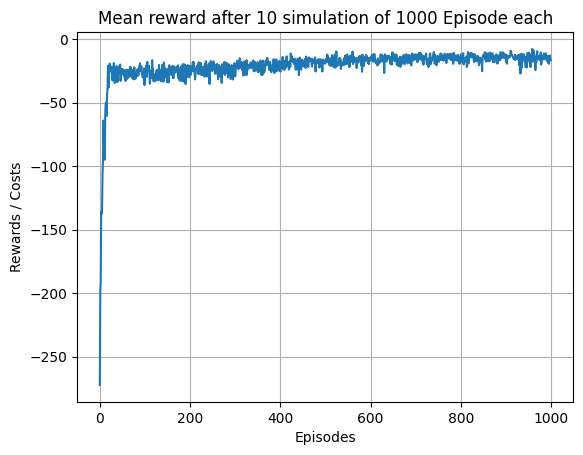

In [158]:
import matplotlib.pyplot as plt

plt.plot(Mean_total_reward)
plt.grid()
plt.title(f'Mean reward after {SIM_RUN} simulation of {TOTAL_EPISODES} Episode each')
plt.xlabel('Episodes')
plt.ylabel('Rewards / Costs')
plt.show()

In [159]:
# Total_running_reward

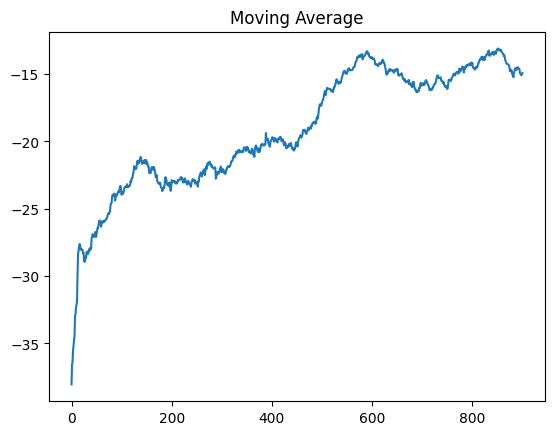

In [160]:
# Moving average
N = 100
cumsum, moving_aves = [0], []

for i, x in enumerate(Total_running_reward, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)

plt.plot(moving_aves)
plt.title('Moving Average')
plt.show()

In [161]:
# episode_lengths

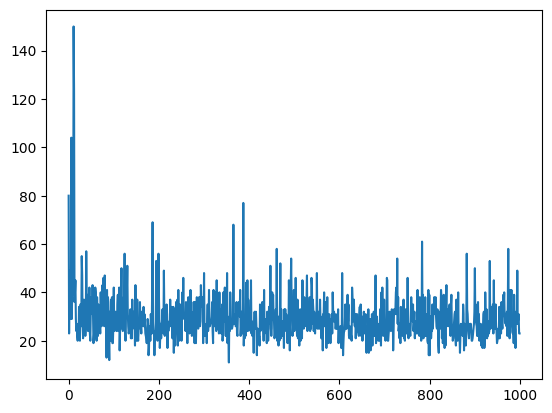

In [162]:
plt.plot(episode_lengths)

In [163]:
Q_table

{'00': {0: array([-2.10493531]),
  1: array([-0.08713353]),
  2: array([-5.8318548])},
 '01': {0: array([-3.4542498]),
  1: array([-1.78259649]),
  2: array([0.15191835])},
 '02': {0: array([-15.37562208]),
  1: array([-15.4483938]),
  2: array([-15.45532719])},
 '10': {0: array([-2.87009088]),
  1: array([0.02350261]),
  2: array([-6.02797568])},
 '11': {0: array([-3.72986969]),
  1: array([-2.58536137]),
  2: array([-0.18749967])},
 '12': {0: array([-16.99613132]),
  1: array([-17.07755955]),
  2: array([-17.03417252])},
 '20': {0: array([-1.76716215]),
  1: array([-0.02269326]),
  2: array([-8.94252162])},
 '21': {0: array([-1.63624354]),
  1: array([-1.256162]),
  2: array([0.07052133])},
 '22': {0: array([-17.27691322]),
  1: array([-17.37653002]),
  2: array([-17.34408822])},
 '30': {0: array([-2.39907246]),
  1: array([-0.19723197]),
  2: array([-8.19433444])},
 '31': {0: array([-3.44797594]),
  1: array([-1.3792397]),
  2: array([0.26501199])},
 '32': {0: array([-17.5493425]),
